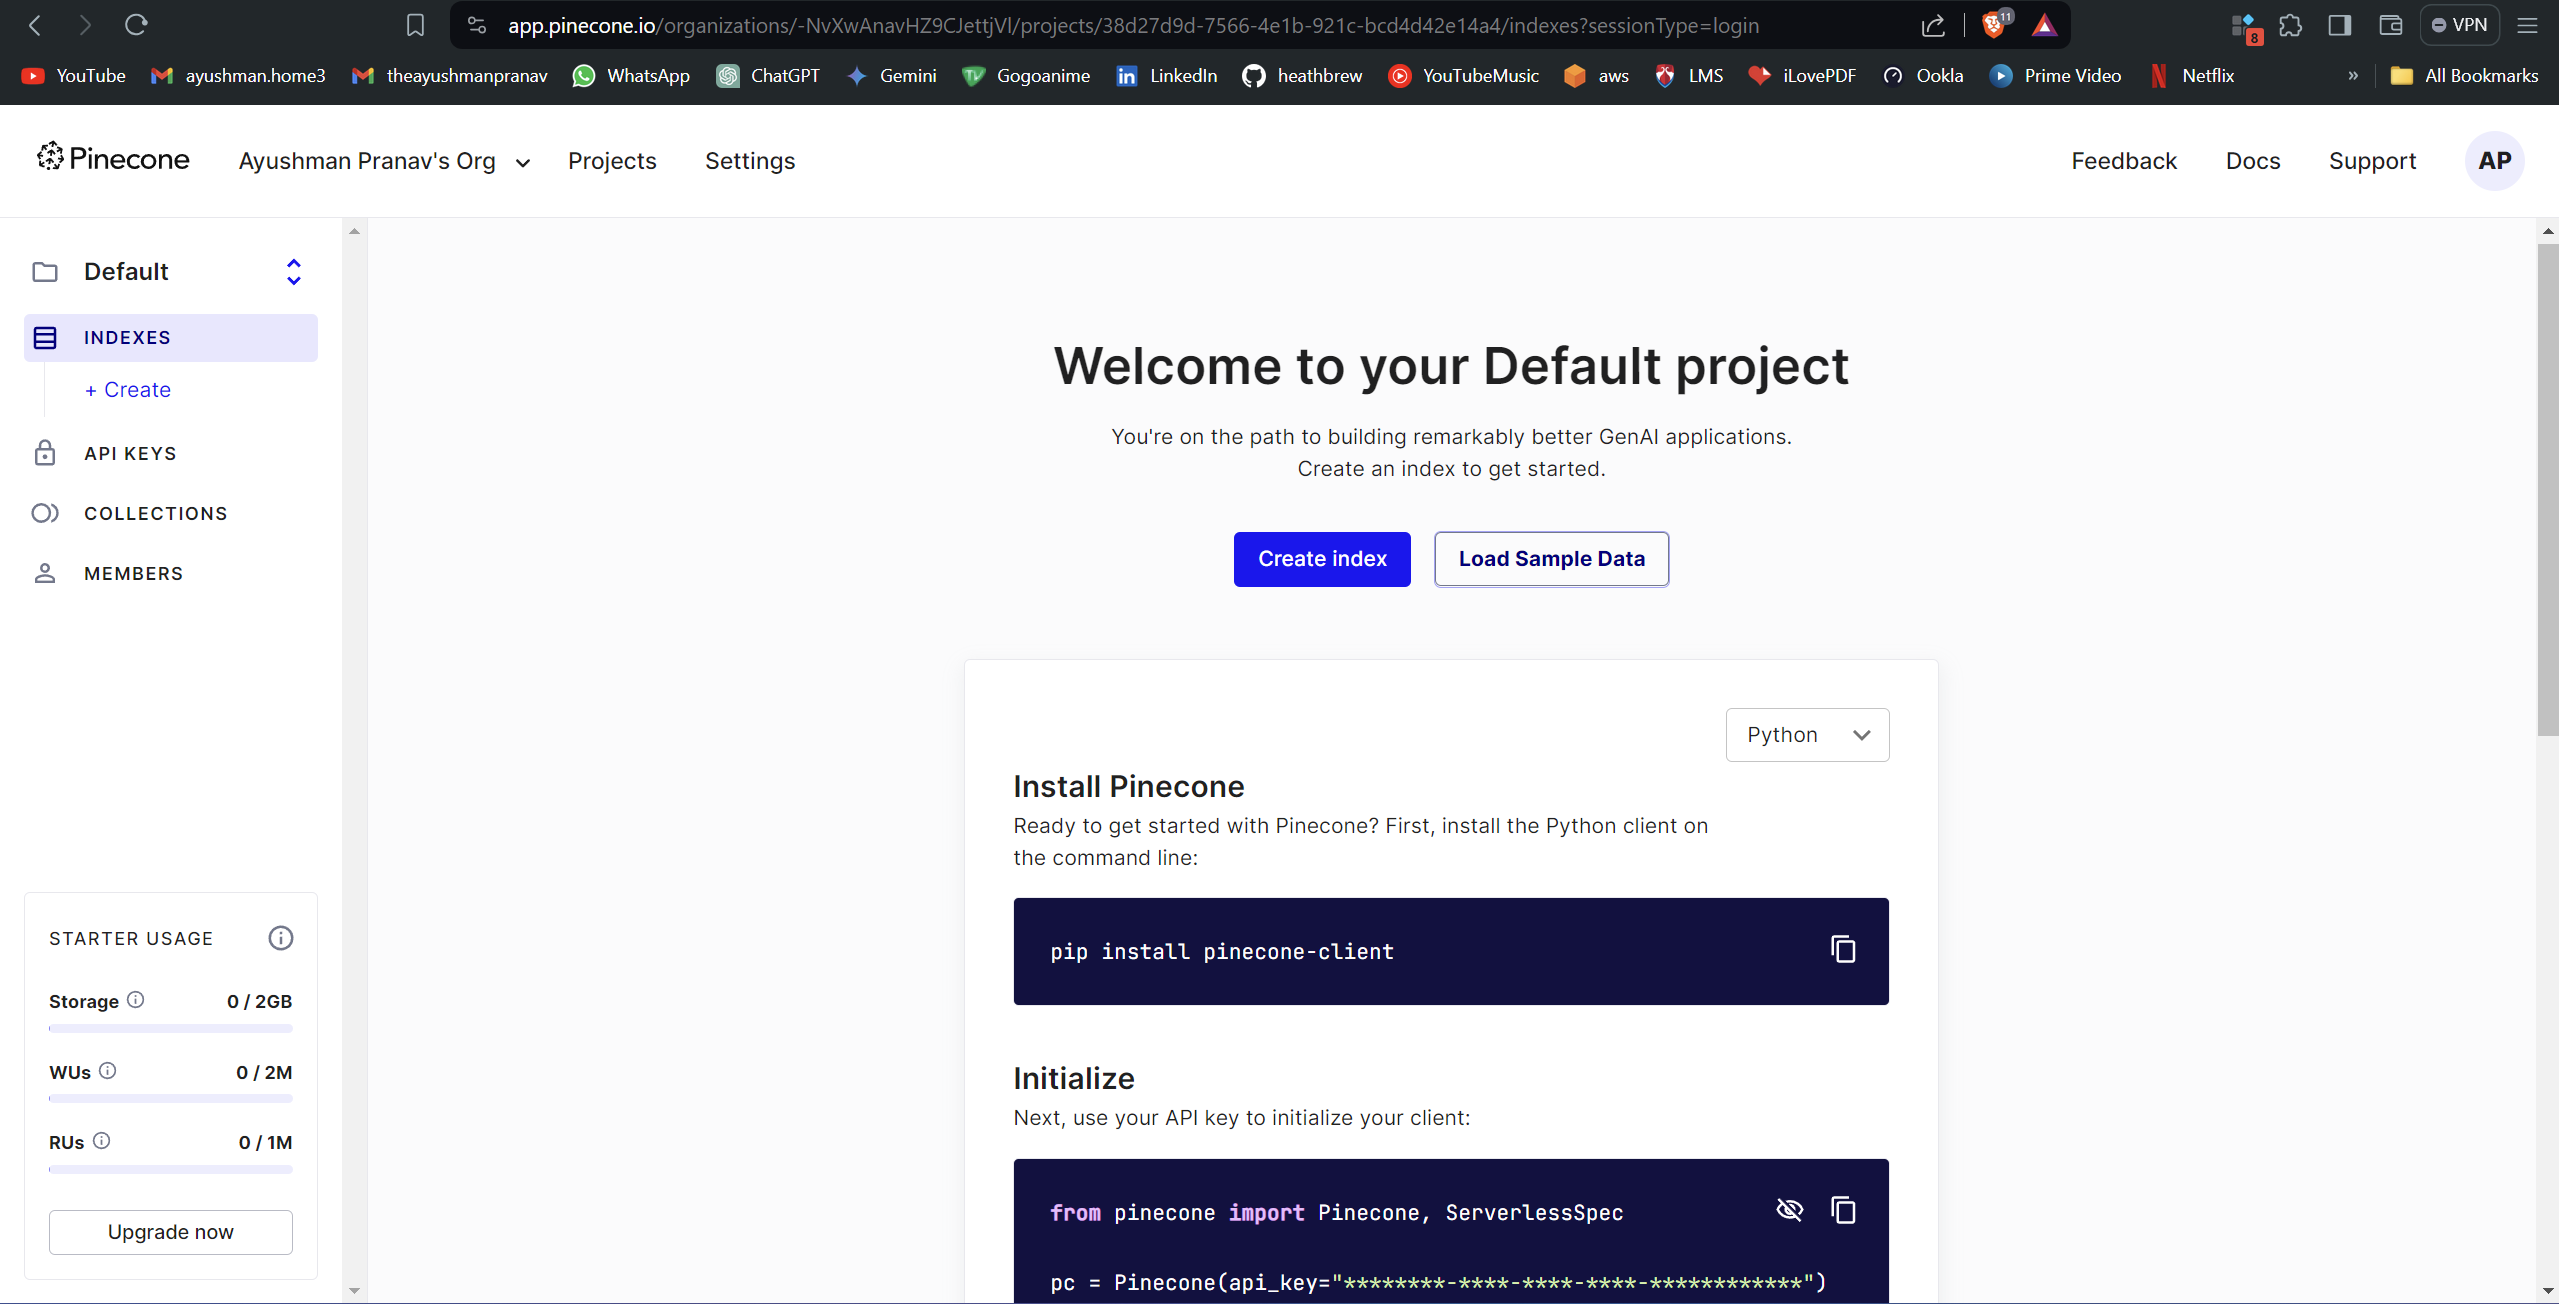

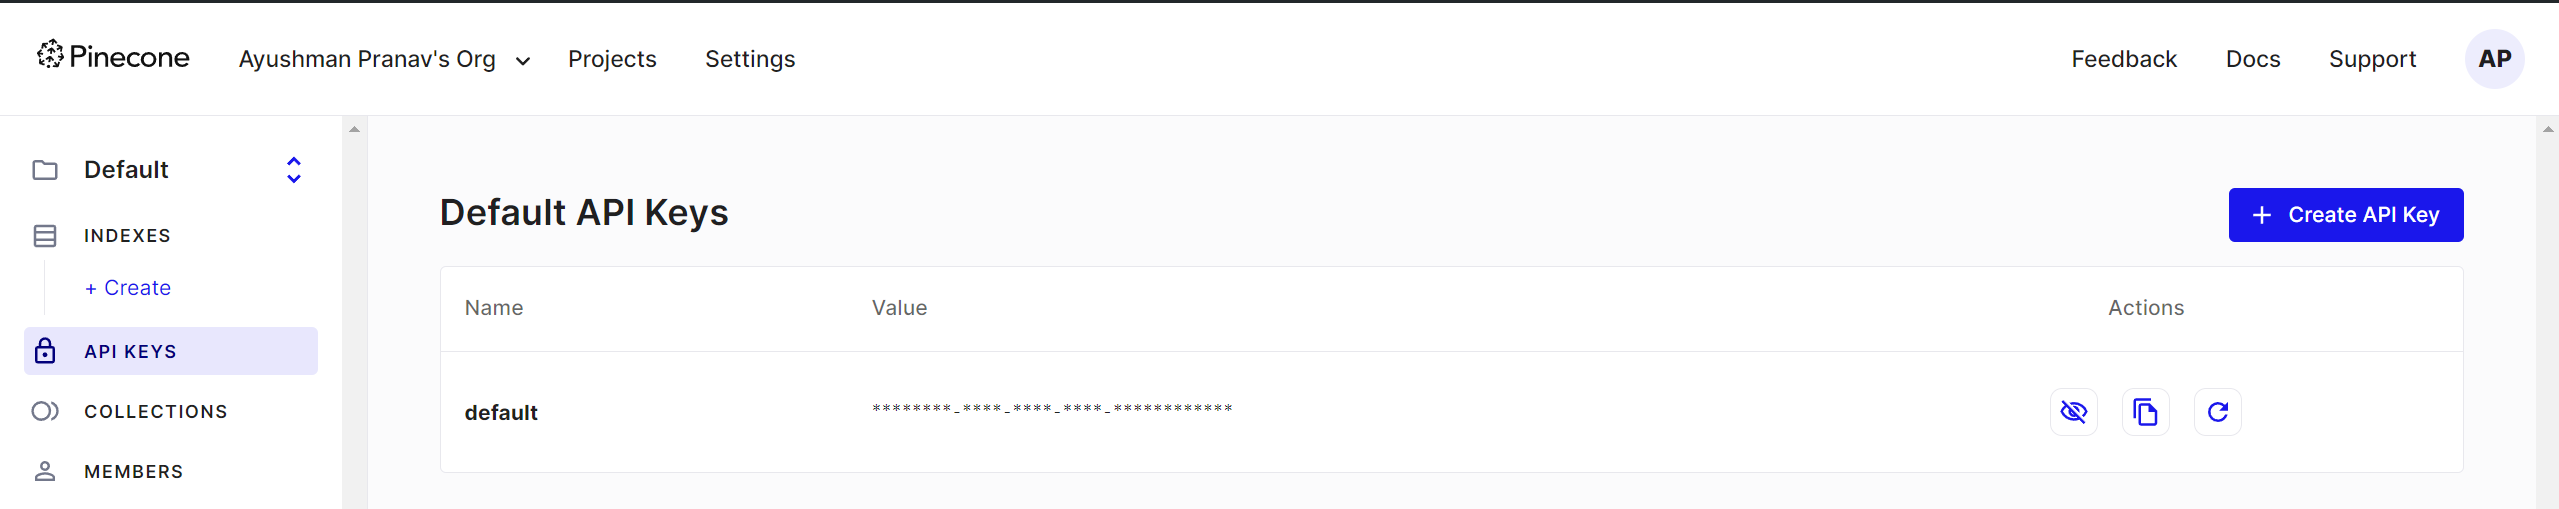

In [1]:
import os

In [2]:
%pwd

'D:\\Desktop\\Superteams AI\\Task 2 Vector Databases can help with Anomaly Detection\\Vector-Databases-can-help-with-Anomaly-Detection\\Research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'D:\\Desktop\\Superteams AI\\Task 2 Vector Databases can help with Anomaly Detection\\Vector-Databases-can-help-with-Anomaly-Detection'

In [5]:
import logging
from pathlib import Path
logging.basicConfig(
    # filename='extract_data.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [6]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("Dataset/financial_news.csv")
df.head()

title  \
0  India's exports dip marginally in March; 3.11%...   
1      Vi expects 5G rollout in 6-9 months after FPO   
2  Byju's India CEO Arjun Mohan quits, Raveendran...   
3  Sensex, Nifty tank over 1% on concerns over Mi...   
4  Wholesale inflation inches up marginally to 0....   

                                             summary  \
0  India's exports dip marginally in March; 3.11%...   
1  Vi expects 5G rollout in 6-9 months after FPO\...   
2  Byju's India CEO Arjun Mohan quits, Raveendran...   
3  Sensex, Nifty tank over 1% on concerns over Mi...   
4  Wholesale inflation inches up marginally to 0....   

                                                link      published  
0  https://realtime.rediff.com/news/business/Indi...  1 hour(s) ago  
1  https://realtime.rediff.com/news/business/Vi-e...  2 hour(s) ago  
2  https://realtime.rediff.com/news/business/Byju...  3 hour(s) ago  
3  https://realtime.rediff.com/news/business/Sens...  6 hour(s) ago  
4  https://realtime.rediff.com/news/business/Whol...  7 hour(s) ago

In [7]:
logging.info("Loaded financial news dataset")

2024-04-16 01:53:16 - INFO - Loaded financial news dataset


# Loading embeddding Model

In [8]:
from sentence_transformers import SentenceTransformer

D:\Desktop\Superteams AI\Task 2 Vector Databases can help with Anomaly Detection\Vector-Databases-can-help-with-Anomaly-Detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# from transformers import AutoTokenizer, AutoModel
# from pathlib import Path

# def download_model_and_tokenizer(model_name, save_path):
#     """
#     Download and save both the model and the tokenizer to the specified directory.

#     Parameters:
#         model_name (str): Name of the model to download.
#         save_path (str or Path): Path to the directory where the model and tokenizer will be saved.
#     """
#     # Create the save path if it doesn't exist
#     save_path = Path(save_path)
#     save_path.mkdir(parents=True, exist_ok=True)
    
#     # Initialize tokenizer and model
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModel.from_pretrained(model_name)
    
#     # Save tokenizer
#     tokenizer.save_pretrained(save_path)
    
#     # Save model
#     model.save_pretrained(save_path)

# # Example usage
# model_name = 'sentence-transformers/all-MiniLM-L12-v2'  # Model name to download
# save_path = Path("MiniLM-L12-v2/")  # Path where model and tokenizer will be saved
# download_model_and_tokenizer(model_name, save_path)


In [10]:
from transformers import AutoTokenizer, AutoModel

def load_model_and_tokenizer(model_path):
    """
    Load the model and tokenizer from the specified directory.

    Parameters:
        model_path (str or Path): Path to the directory containing the saved model and tokenizer.

    Returns:
        tokenizer (transformers.PreTrainedTokenizer): Loaded tokenizer.
        model (transformers.PreTrainedModel): Loaded model.
    """
    model_path = Path(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    return tokenizer, model

# Load the model and tokenizer
model_path = Path("MiniLM-L12-v2/")
tokenizer, model = load_model_and_tokenizer(model_path)

In [11]:
logging.info("Initialized SentenceTransformer model")

2024-04-16 01:53:23 - INFO - Initialized SentenceTransformer model


In [12]:
df['news'] = df.apply(lambda row: row['title'] + ' ' + row['summary'], axis=1)
df.head()

title  \
0  India's exports dip marginally in March; 3.11%...   
1      Vi expects 5G rollout in 6-9 months after FPO   
2  Byju's India CEO Arjun Mohan quits, Raveendran...   
3  Sensex, Nifty tank over 1% on concerns over Mi...   
4  Wholesale inflation inches up marginally to 0....   

                                             summary  \
0  India's exports dip marginally in March; 3.11%...   
1  Vi expects 5G rollout in 6-9 months after FPO\...   
2  Byju's India CEO Arjun Mohan quits, Raveendran...   
3  Sensex, Nifty tank over 1% on concerns over Mi...   
4  Wholesale inflation inches up marginally to 0....   

                                                link      published  \
0  https://realtime.rediff.com/news/business/Indi...  1 hour(s) ago   
1  https://realtime.rediff.com/news/business/Vi-e...  2 hour(s) ago   
2  https://realtime.rediff.com/news/business/Byju...  3 hour(s) ago   
3  https://realtime.rediff.com/news/business/Sens...  6 hour(s) ago   
4  https://realtime.rediff.com/news/business/Whol...  7 hour(s) ago   

                                                news  
0  India's exports dip marginally in March; 3.11%...  
1  Vi expects 5G rollout in 6-9 months after FPO ...  
2  Byju's India CEO Arjun Mohan quits, Raveendran...  
3  Sensex, Nifty tank over 1% on concerns over Mi...  
4  Wholesale inflation inches up marginally to 0....

# embedding the data 

In [13]:
import torch

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def generate_embedding(text):
    # Tokenize input text
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    # Compute token embeddings with model
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Perform mean pooling
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    # Convert to numpy for FAISS compatibility and ensure it's 2D
    return sentence_embedding.cpu().numpy().reshape(1, -1)

In [14]:
# Generate embeddings for the 'input' column
df['encoded_news'] = df['news'].apply(lambda x: generate_embedding(x)[0].tolist())
df.head()

title  \
0  India's exports dip marginally in March; 3.11%...   
1      Vi expects 5G rollout in 6-9 months after FPO   
2  Byju's India CEO Arjun Mohan quits, Raveendran...   
3  Sensex, Nifty tank over 1% on concerns over Mi...   
4  Wholesale inflation inches up marginally to 0....   

                                             summary  \
0  India's exports dip marginally in March; 3.11%...   
1  Vi expects 5G rollout in 6-9 months after FPO\...   
2  Byju's India CEO Arjun Mohan quits, Raveendran...   
3  Sensex, Nifty tank over 1% on concerns over Mi...   
4  Wholesale inflation inches up marginally to 0....   

                                                link      published  \
0  https://realtime.rediff.com/news/business/Indi...  1 hour(s) ago   
1  https://realtime.rediff.com/news/business/Vi-e...  2 hour(s) ago   
2  https://realtime.rediff.com/news/business/Byju...  3 hour(s) ago   
3  https://realtime.rediff.com/news/business/Sens...  6 hour(s) ago   
4  https://realtime.rediff.com/news/business/Whol...  7 hour(s) ago   

                                                news  \
0  India's exports dip marginally in March; 3.11%...   
1  Vi expects 5G rollout in 6-9 months after FPO ...   
2  Byju's India CEO Arjun Mohan quits, Raveendran...   
3  Sensex, Nifty tank over 1% on concerns over Mi...   
4  Wholesale inflation inches up marginally to 0....   

                                        encoded_news  
0  [0.11521313339471817, -0.300284206867218, -0.0...  
1  [-0.11326470226049423, -0.1829032599925995, 0....  
2  [0.169069305062294, 0.021063419058918953, -0.1...  
3  [0.08247419446706772, -0.09446192532777786, -0...  
4  [0.2434849739074707, 0.027635755017399788, 0.0...

# Creating a vector store in pine cone 

In [15]:
from pinecone import Pinecone, ServerlessSpec
from pineconeapikey import pineconeapikey

In [16]:
# Initialize Pinecone
pc = Pinecone(api_key=pineconeapikey())
logging.info("Initialized Pinecone")


2024-04-16 01:53:26 - INFO - Initialized Pinecone


In [17]:
index_name = "financial-news-index"

# Check if the index already exists
if 'financial-news-index' not in pc.list_indexes().names():
    logging.info(f"Creating new index: {index_name}")
    # Get the embedding dimension from the model configuration
    embedding_dim = model.config.hidden_size
    # Create a new index if it doesn't already exist
    pc.create_index(
        name=index_name,
        dimension=embedding_dim,
        metric="cosine",
        spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    ) 
    )
else:
    logging.info(f"Index '{index_name}' already exists")

index = pc.Index(index_name)

2024-04-16 01:53:27 - INFO - Creating new index: financial-news-index


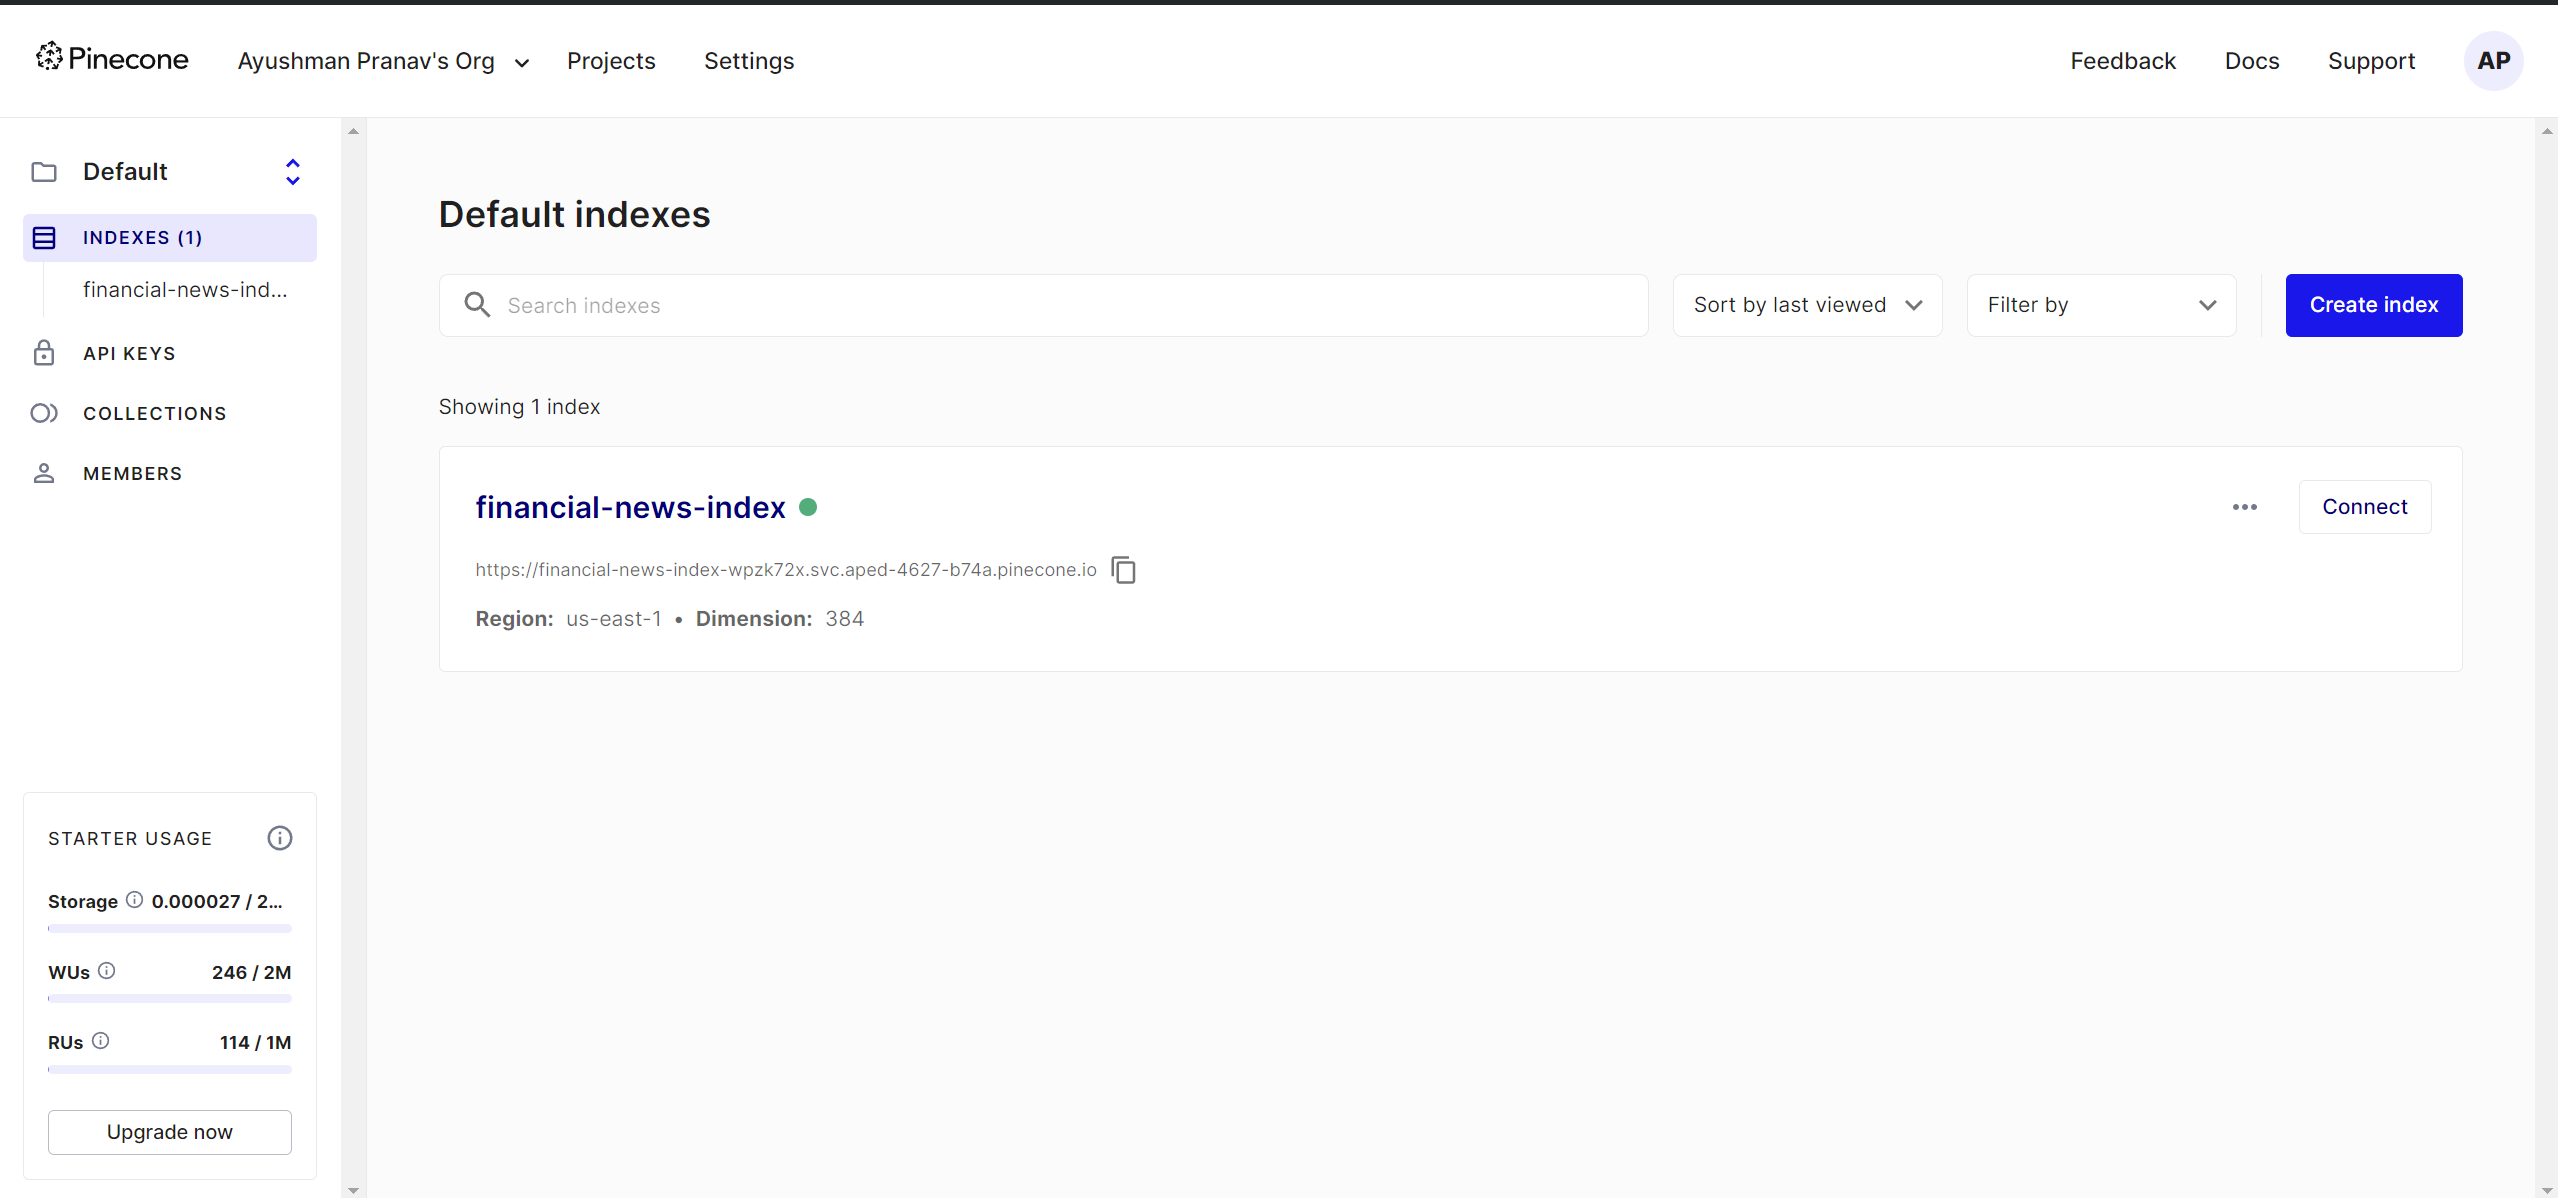

# pushing data to pine cone

In [18]:
import itertools

# Initialize Pinecone and create an index
pc = Pinecone(api_key=pineconeapikey())
index = pc.Index(index_name)

def chunks(iterable, batch_size=100):
    """A helper function to break an iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))



# Extract necessary columns from the DataFrame
encoded_news = df['encoded_news']
news = df['news']

# Process the data and combine into a list of dictionaries
formatted_data = []
for idx, (encoded, text) in enumerate(zip(encoded_news, news)):
    try:
        # Create a dictionary representing a data point
        data_point = {"id": str(idx), "values": encoded, "metadata": {"text": text}}
        formatted_data.append(data_point)
        logging.info(f"Processed and encoded summary {idx + 1}")
    except Exception as e:
        logging.error(f"Error processing data point {idx + 1}: {e}")
        continue  # Skip to the next data point if an error occurs

# Upsert the formatted embeddings to the index in batches
for ids_vectors_chunk in chunks(formatted_data, batch_size=10):
    index.upsert(vectors=ids_vectors_chunk)  


2024-04-16 01:53:31 - INFO - Processed and encoded summary 1
2024-04-16 01:53:31 - INFO - Processed and encoded summary 2
2024-04-16 01:53:31 - INFO - Processed and encoded summary 3
2024-04-16 01:53:31 - INFO - Processed and encoded summary 4
2024-04-16 01:53:31 - INFO - Processed and encoded summary 5
2024-04-16 01:53:31 - INFO - Processed and encoded summary 6
2024-04-16 01:53:31 - INFO - Processed and encoded summary 7
2024-04-16 01:53:31 - INFO - Processed and encoded summary 8
2024-04-16 01:53:31 - INFO - Processed and encoded summary 9
2024-04-16 01:53:31 - INFO - Processed and encoded summary 10


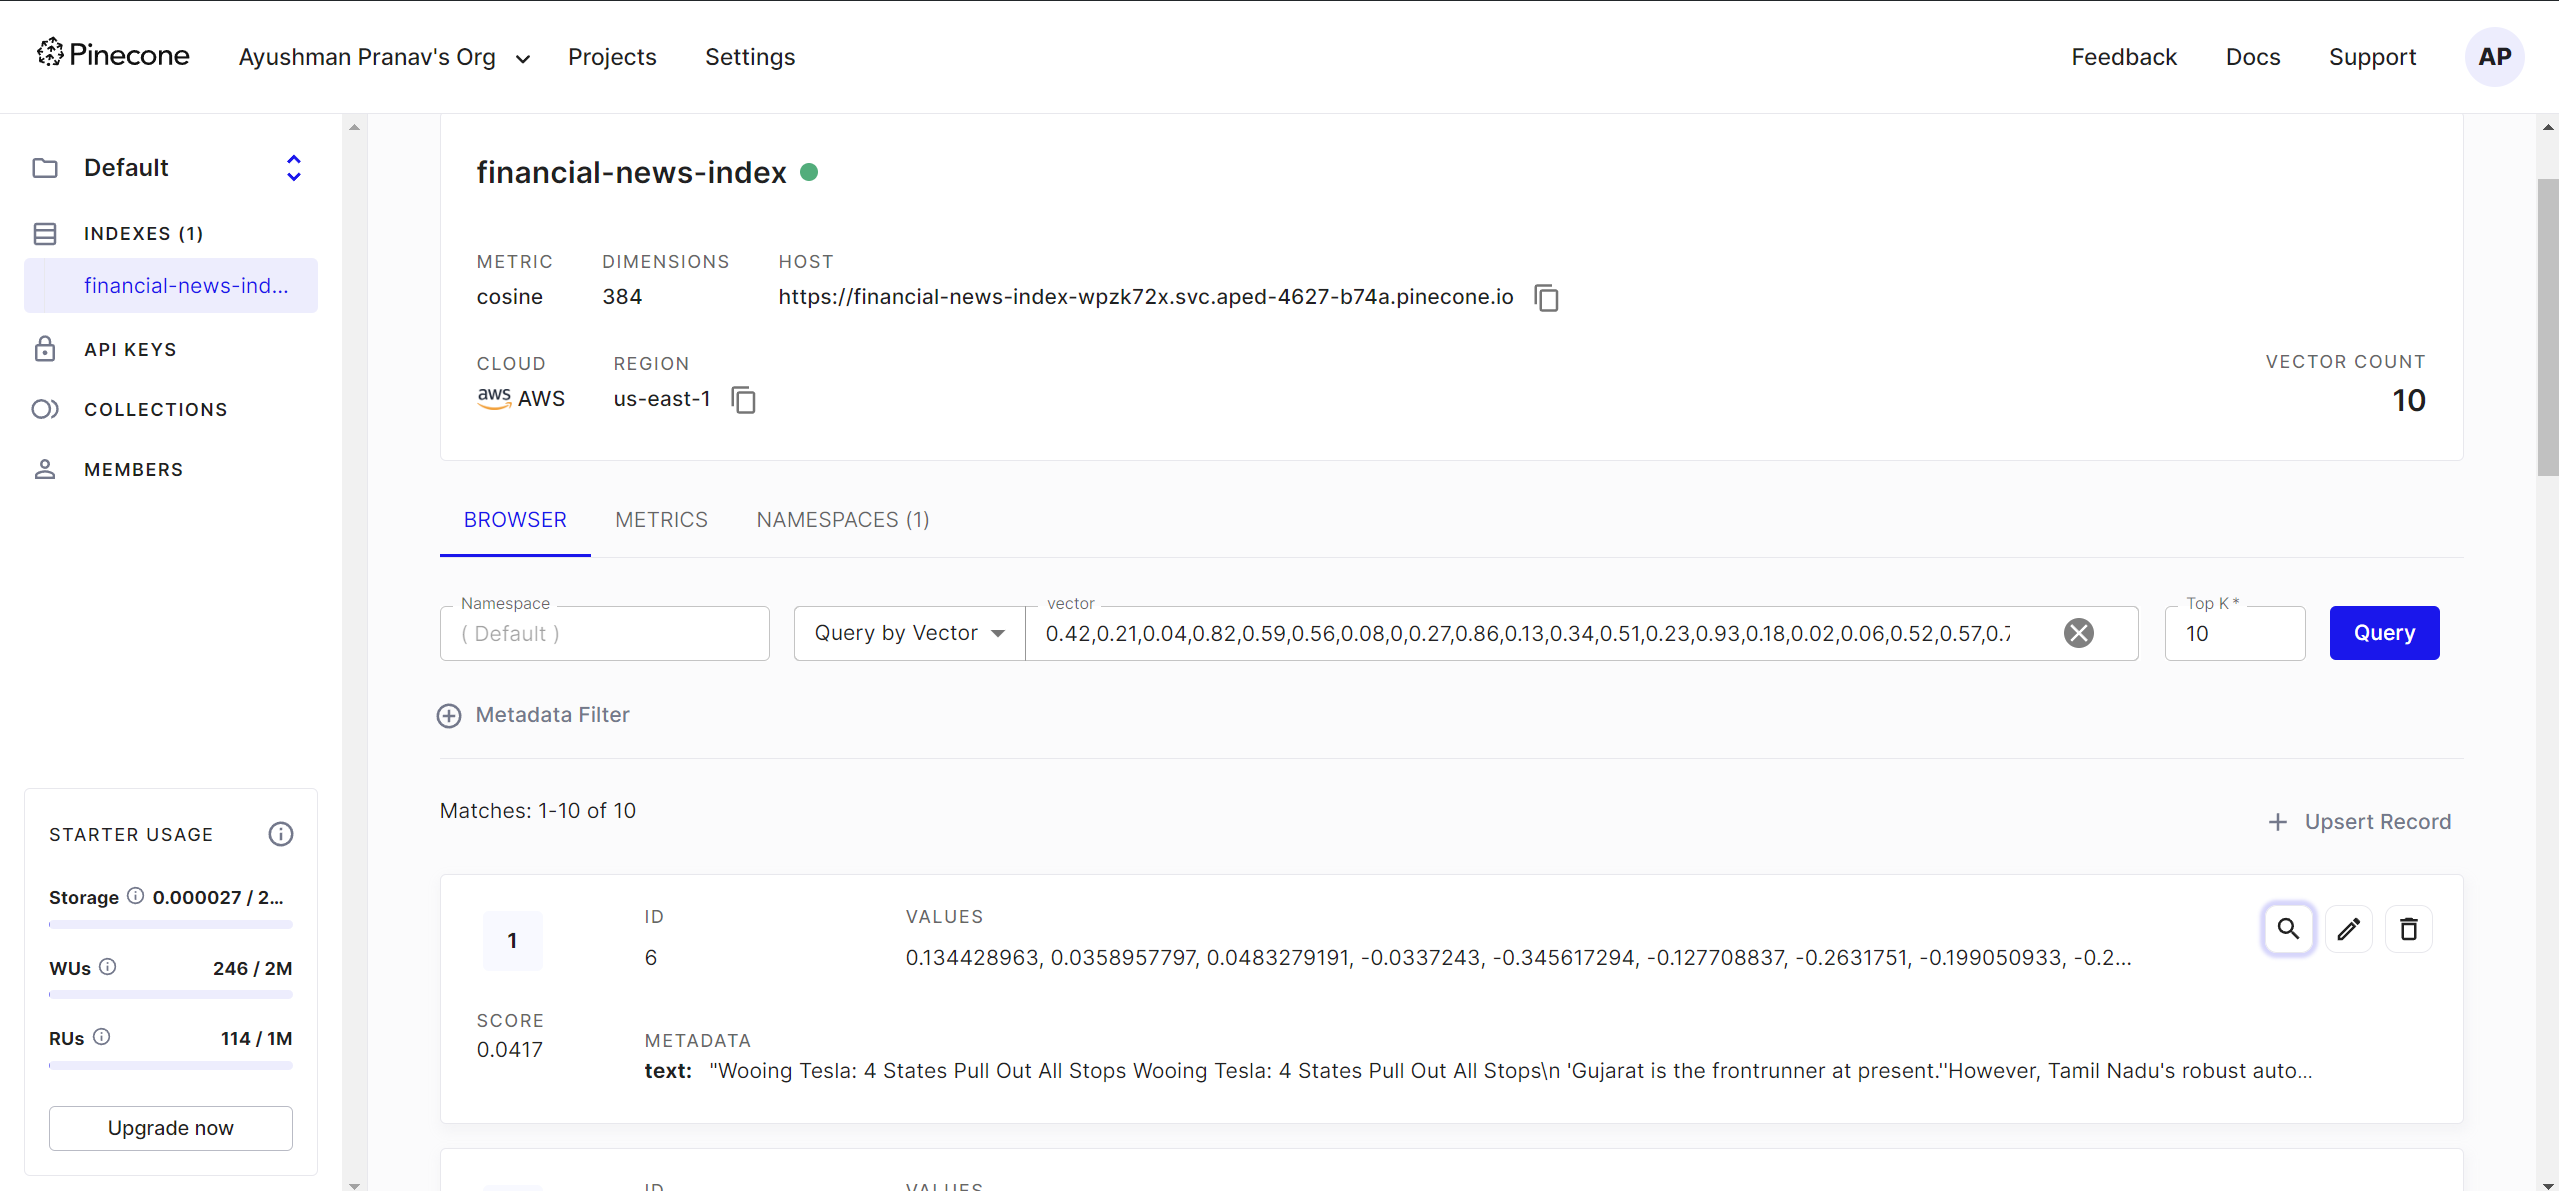

# Querying pinecone

In [19]:
query = "Stock market crashes due to unexpected event"

# create the query vector
xq = generate_embedding(query).tolist()

# now query
xc = index.query(vector=xq, top_k=3, include_metadata=True)
xc

{'matches': [], 'namespace': '', 'usage': {'read_units': 6}}

In [20]:
for result in xc['matches']:
    print(f"{round(result['score'], 2)}: {result['metadata']['text']}")

In [21]:
# Initialize an empty string to store concatenated results
concatenated_results = ""

# Iterate over the matches and concatenate each result
for result in xc['matches']:
    concatenated_results += f"{round(result['score'], 2)}: {result['metadata']['text']}\n"

# Print or use the concatenated results as needed
print(concatenated_results)


# RAG using Llama2

In [22]:
print(str(query + concatenated_results)[:512])

Stock market crashes due to unexpected event


In [23]:
from llama2backend import generate_text

RAG_answer = generate_text(str(query + concatenated_results)[:512])

D:\Desktop\Superteams AI\Task 2 Vector Databases can help with Anomaly Detection\Vector-Databases-can-help-with-Anomaly-Detection\venv\Lib\site-packages\langchain_core\utils\utils.py:159: UserWarning: WARNING! model_url is not default parameter.
                model_url was transferred to model_kwargs.
                Please confirm that model_url is what you intended.
  warnings.warn(
D:\Desktop\Superteams AI\Task 2 Vector Databases can help with Anomaly Detection\Vector-Databases-can-help-with-Anomaly-Detection\venv\Lib\site-packages\langchain_core\utils\utils.py:159: UserWarning: WARNING! max_new_tokens is not default parameter.
                max_new_tokens was transferred to model_kwargs.
                Please confirm that max_new_tokens is what you intended.
  warnings.warn(
D:\Desktop\Superteams AI\Task 2 Vector Databases can help with Anomaly Detection\Vector-Databases-can-help-with-Anomaly-Detection\venv\Lib\site-packages\langchain_core\utils\utils.py:159: UserWarning: WARN


 Unterscheidung between a stock market crash and a stock market correction is often blurry, but there are some key differences. A stock market crash refers to a sudden and significant decline in stock prices, often triggered by an external event or factor. On the other hand, a stock market correction refers to a more gradual decline in stock prices that occurs over a longer period of time.
Some common causes of a stock market crash include:
1. Economic shocks: A severe economic downturn, such as a recession or depression, can lead to a stock market crash. For example, the 2008 global financial crisis caused a significant decline in stock prices worldwide.
2. Political instability: Political instability or conflict can also cause a stock market crash. For instance, the Russian invasion of Ukraine in 2014 led to a sharp decline in global stock markets.
3. Natural disasters: Severe natural disasters, such as hurricanes, earthquakes, or tsunamis, can cause a stock market crash by disrupti


llama_print_timings:        load time =     227.29 ms
llama_print_timings:      sample time =     101.64 ms /   256 runs   (    0.40 ms per token,  2518.59 tokens per second)
llama_print_timings: prompt eval time =     227.21 ms /     8 tokens (   28.40 ms per token,    35.21 tokens per second)
llama_print_timings:        eval time =    6450.63 ms /   255 runs   (   25.30 ms per token,    39.53 tokens per second)
llama_print_timings:       total time =    8483.82 ms /   263 tokens


In [24]:
RAG_answer

'\n Unterscheidung between a stock market crash and a stock market correction is often blurry, but there are some key differences. A stock market crash refers to a sudden and significant decline in stock prices, often triggered by an external event or factor. On the other hand, a stock market correction refers to a more gradual decline in stock prices that occurs over a longer period of time.\nSome common causes of a stock market crash include:\n1. Economic shocks: A severe economic downturn, such as a recession or depression, can lead to a stock market crash. For example, the 2008 global financial crisis caused a significant decline in stock prices worldwide.\n2. Political instability: Political instability or conflict can also cause a stock market crash. For instance, the Russian invasion of Ukraine in 2014 led to a sharp decline in global stock markets.\n3. Natural disasters: Severe natural disasters, such as hurricanes, earthquakes, or tsunamis, can cause a stock market crash by di